# Drug Causality Classification using BioBERT

This notebook demonstrates the complete workflow for drug-adverse event causality assessment using a fine-tuned BioBERT model.

## Performance Metrics
- F1 Score: 0.9759
- Accuracy: 0.9759
- Sensitivity: 0.9868
- Specificity: 0.9650

## 1. Setup and Installation

First, let's install all required dependencies.

In [1]:
# Install required packages
!pip install torch>=2.1.0 transformers>=4.35.0 pandas numpy scikit-learn nltk>=3.7 PyPDF2>=3.0.1 safetensors>=0.4.0

## 2. Import Libraries

In [2]:
import sys
import os
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd() / 'src'))

import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import PyPDF2
import json
from datetime import datetime

# Import custom inference module
from inference import CausalityClassifier, classify_causality, process_pdf_file, process_multiple_pdfs, extract_text_from_pdf

print("✓ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

C:\Users\koreo\drug-causality-bert\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ punkt already available
✓ punkt_tab already available
✓ All libraries imported successfully!
PyTorch version: 2.9.0+cpu
CUDA available: False


## 3. Download NLTK Data

Download required NLTK data for sentence tokenization.

In [3]:
import nltk
import ssl

# SSL fix for NLTK
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download NLTK data
try:
    nltk.download('punkt')
    nltk.download('punkt_tab')
    print("✓ NLTK data downloaded successfully!")
except Exception as e:
    print(f"Warning: NLTK download issue: {e}")
    print("Will use fallback tokenizer if needed.")

✓ NLTK data downloaded successfully!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\koreo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\koreo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 4. Load the Pre-trained Model

Load the fine-tuned BioBERT model for causality classification.

In [4]:
# Define model path
MODEL_PATH = './models/production_model_final'
THRESHOLD = 0.5  # Classification threshold

# Initialize the classifier
print("Loading model...")
classifier = CausalityClassifier(model_path=MODEL_PATH, threshold=THRESHOLD)
print("✓ Model loaded successfully!")
print(f"Model path: {MODEL_PATH}")
print(f"Classification threshold: {THRESHOLD}")

Loading model...
✓ Model loaded successfully!
Model path: ./models/production_model_final
Classification threshold: 0.5


## 5. Test with Sample Text

Let's test the model with some sample sentences.

In [5]:
# Sample test sentences
test_sentences = [
    "The patient developed severe rash after taking the medication.",
    "The patient's blood pressure was monitored regularly.",
    "Adverse reaction to the drug resulted in hospitalization.",
    "The weather was sunny and pleasant.",
    "Patient experienced nausea and vomiting following drug administration."
]

print("Testing model with sample sentences:\n")
print("=" * 80)

for i, sentence in enumerate(test_sentences, 1):
    result = classifier.predict(sentence, return_probs=True)
    print(f"\nSentence {i}: {sentence}")
    print(f"Prediction: {result['prediction'].upper()}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Probabilities:")
    print(f"  - Not Related: {result['probabilities']['not_related']:.4f}")
    print(f"  - Related: {result['probabilities']['related']:.4f}")
    print("-" * 80)

Testing model with sample sentences:


Sentence 1: The patient developed severe rash after taking the medication.
Prediction: NOT RELATED
Confidence: 1.0000
Probabilities:
  - Not Related: 1.0000
  - Related: 0.0000
--------------------------------------------------------------------------------

Sentence 2: The patient's blood pressure was monitored regularly.
Prediction: NOT RELATED
Confidence: 1.0000
Probabilities:
  - Not Related: 1.0000
  - Related: 0.0000
--------------------------------------------------------------------------------

Sentence 3: Adverse reaction to the drug resulted in hospitalization.
Prediction: NOT RELATED
Confidence: 1.0000
Probabilities:
  - Not Related: 1.0000
  - Related: 0.0000
--------------------------------------------------------------------------------

Sentence 4: The weather was sunny and pleasant.
Prediction: NOT RELATED
Confidence: 1.0000
Probabilities:
  - Not Related: 1.0000
  - Related: 0.0000
------------------------------------------------

## 6. Process PDF Documents

Now let's process PDF documents to classify drug causality.

### 6.1 Single PDF Processing

Process a single PDF file. Replace the path with your actual PDF file.

In [14]:
# Example: Process a single PDF
# Replace 'your_pdf_file.pdf' with the actual path to your PDF

pdf_path = './data/raw/fphar-16-1498191.pdf'  # Update this path

# Check if file exists
if os.path.exists(pdf_path):
    print(f"Processing PDF: {pdf_path}\n")
    
    # Process the PDF
    results = process_pdf_file(
        pdf_path=pdf_path,
        model_path=MODEL_PATH,
        threshold=THRESHOLD,
        save_report=True,
        output_dir='./results'
    )
    
    # Display results
    print("=" * 80)
    print("RESULTS")
    print("=" * 80)
    print(f"PDF File: {results['pdf_file']}")
    print(f"Final Classification: {results['final_classification'].upper()}")
    print(f"Confidence Score: {results['confidence_score']:.4f}")
    print(f"Related Sentences: {results['related_sentences']} / {results['total_sentences']}")
    print(f"Threshold Used: {results['threshold_used']}")
    
    print("\nTop 5 Related Sentences:")
    print("-" * 80)
    for i, sent_info in enumerate(results['top_related_sentences'], 1):
        print(f"\n{i}. {sent_info['sentence']}...")
        print(f"   Probability: {sent_info['probability_related']:.4f}")
        print(f"   Confidence: {sent_info['confidence']:.4f}")
    
    print("\n✓ Results saved to ./results/")
else:
    print(f"⚠ PDF file not found: {pdf_path}")
    print("Please update the pdf_path variable with the correct file path.")

Processing PDF: ./data/raw/fphar-16-1498191.pdf

RESULTS
PDF File: fphar-16-1498191.pdf
Final Classification: RELATED
Confidence Score: 0.0458
Related Sentences: 19 / 415
Threshold Used: 0.5

Top 5 Related Sentences:
--------------------------------------------------------------------------------

1. Adalimumab, commonly used for th e treatment of severe uveitis
associated with juvenile idiopath ic ...
   Probability: 0.9999
   Confidence: 0.9999

2. Interferon Beta-1A, indicated for multiple sclerosis, was also
identi ﬁed as potentially associated ...
   Probability: 0.9999
   Confidence: 0.9999

3. Further research is warranted to elucidate the underlyingmechanisms and explore the epidemiology of ...
   Probability: 0.9999
   Confidence: 0.9999

4. In the RESONATE phase III
multicenter trial, among approximately 400 patients withrelapsed or refrac...
   Probability: 0.9999
   Confidence: 0.9999

5. Our analysis suggests thatesomeprazole may be an independent risk factor for cataracts

### 6.2 Batch PDF Processing

Process multiple PDF files at once.

In [7]:
# Example: Process multiple PDFs
# Add your PDF file paths to this list

pdf_files = [
    './data/raw/document1.pdf',
    './data/raw/document2.pdf',
    './data/raw/document3.pdf'
]

# Filter only existing files
existing_pdfs = [pdf for pdf in pdf_files if os.path.exists(pdf)]

if existing_pdfs:
    print(f"Processing {len(existing_pdfs)} PDF files...\n")
    
    # Process all PDFs
    batch_results = process_multiple_pdfs(
        pdf_paths=existing_pdfs,
        model_path=MODEL_PATH,
        threshold=THRESHOLD,
        save_reports=True,
        output_dir='./results'
    )
    
    # Display summary
    print("=" * 80)
    print("BATCH PROCESSING SUMMARY")
    print("=" * 80)
    
    for i, result in enumerate(batch_results, 1):
        print(f"\n{i}. {result['pdf_file']}")
        if 'error' in result:
            print(f"   Status: ERROR - {result['error']}")
        else:
            print(f"   Classification: {result['final_classification'].upper()}")
            print(f"   Confidence: {result['confidence_score']:.4f}")
            print(f"   Related Sentences: {result['related_sentences']}/{result['total_sentences']}")
    
    # Save batch summary
    summary_path = './results/batch_causality_summary.json'
    with open(summary_path, 'w') as f:
        json.dump(batch_results, f, indent=2)
    
    print(f"\n✓ Batch summary saved to {summary_path}")
else:
    print("⚠ No PDF files found in the specified paths.")
    print("Please add your PDF files to the ./data/raw/ directory or update the pdf_files list.")

⚠ No PDF files found in the specified paths.
Please add your PDF files to the ./data/raw/ directory or update the pdf_files list.


## 7. Custom Text Analysis

Analyze custom text without using PDF files.

In [8]:
# Custom text for analysis
custom_text = """
The patient, a 45-year-old male, was prescribed Drug X for hypertension. 
After three days of treatment, the patient developed severe headaches and dizziness. 
The symptoms persisted and worsened over the next week. 
Upon discontinuation of Drug X, the adverse effects gradually subsided. 
The patient's blood pressure was monitored throughout the treatment period.
A rechallenge with Drug X resulted in recurrence of the same symptoms.
"""

print("Analyzing custom text...\n")
print("=" * 80)
print("INPUT TEXT:")
print(custom_text)
print("=" * 80)

# Classify the text
results = classify_causality(
    pdf_text=custom_text,
    model_path=MODEL_PATH,
    threshold=THRESHOLD,
    verbose=True
)

# Display results
print("\n" + "=" * 80)
print("ANALYSIS RESULTS")
print("=" * 80)
print(f"Final Classification: {results['final_classification'].upper()}")
print(f"Confidence Score: {results['confidence_score']:.4f}")
print(f"Related Sentences: {results['related_sentences']} / {results['total_sentences']}")

print("\nTop Related Sentences:")
print("-" * 80)
for i, sent_info in enumerate(results['top_related_sentences'], 1):
    print(f"\n{i}. {sent_info['sentence']}...")
    print(f"   Probability: {sent_info['probability_related']:.4f}")
    print(f"   Confidence: {sent_info['confidence']:.4f}")

Analyzing custom text...

INPUT TEXT:

The patient, a 45-year-old male, was prescribed Drug X for hypertension. 
After three days of treatment, the patient developed severe headaches and dizziness. 
The symptoms persisted and worsened over the next week. 
Upon discontinuation of Drug X, the adverse effects gradually subsided. 
The patient's blood pressure was monitored throughout the treatment period.
A rechallenge with Drug X resulted in recurrence of the same symptoms.

Tokenized 6 sentences

ANALYSIS RESULTS
Final Classification: NOT RELATED
Confidence Score: 0.0000
Related Sentences: 0 / 6

Top Related Sentences:
--------------------------------------------------------------------------------


## 8. Visualize Results

Create visualizations of the classification results.

In [9]:
# Install matplotlib if not already installed
!pip install matplotlib seaborn

  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl (73 kB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)

   ----------- ---------------------------- 2/7 [fonttools]
   ----------- -----

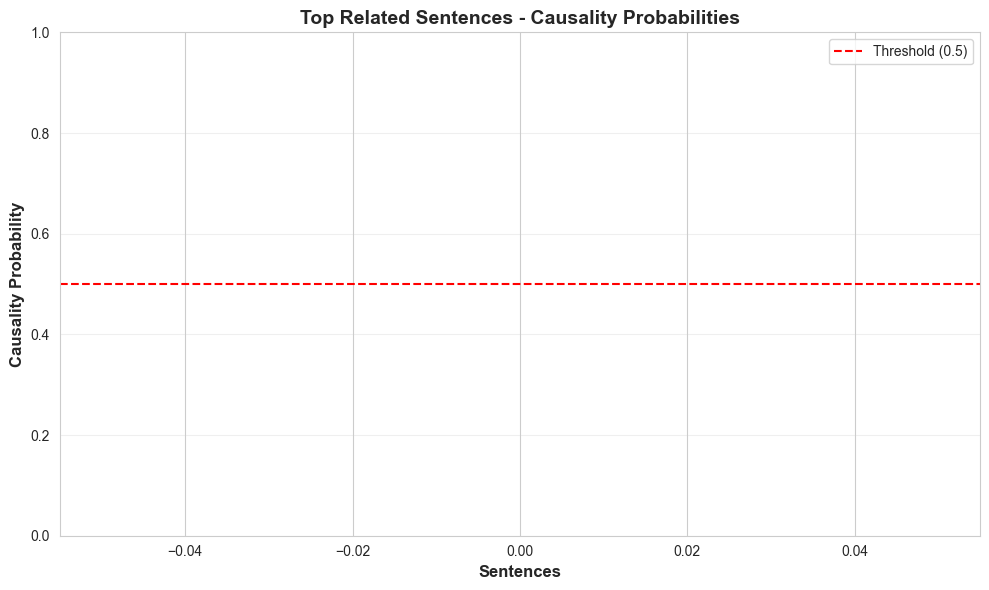

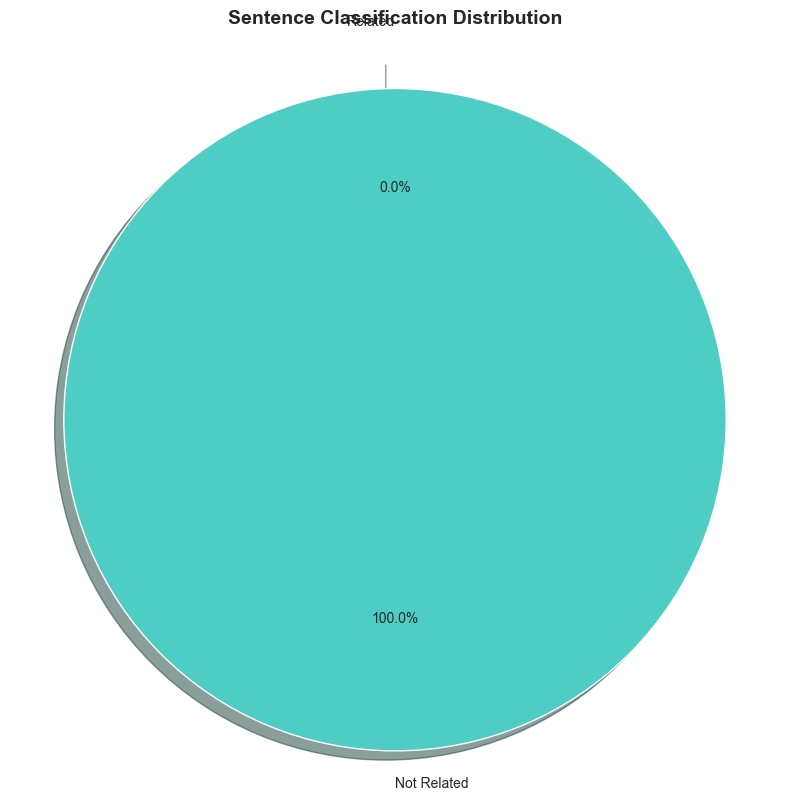

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Example: Visualize sentence-level predictions
if 'results' in locals() and 'top_related_sentences' in results:
    # Extract data
    sentences = [f"Sent {i+1}" for i in range(len(results['top_related_sentences']))]
    probabilities = [s['probability_related'] for s in results['top_related_sentences']]
    
    # Create bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(sentences, probabilities, color='steelblue', alpha=0.7)
    
    # Add threshold line
    plt.axhline(y=THRESHOLD, color='red', linestyle='--', label=f'Threshold ({THRESHOLD})')
    
    # Customize plot
    plt.xlabel('Sentences', fontsize=12, fontweight='bold')
    plt.ylabel('Causality Probability', fontsize=12, fontweight='bold')
    plt.title('Top Related Sentences - Causality Probabilities', fontsize=14, fontweight='bold')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, prob in zip(bars, probabilities):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{prob:.3f}',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Create pie chart for classification
    plt.figure(figsize=(8, 8))
    sizes = [results['related_sentences'], results['total_sentences'] - results['related_sentences']]
    labels = ['Related', 'Not Related']
    colors = ['#ff6b6b', '#4ecdc4']
    explode = (0.1, 0)
    
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=90)
    plt.title('Sentence Classification Distribution', fontsize=14, fontweight='bold')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
else:
    print("No results available for visualization. Please run the analysis first.")

## 9. Model Information

Display detailed information about the loaded model.

In [11]:
print("=" * 80)
print("MODEL INFORMATION")
print("=" * 80)

# Model architecture
print("\nModel Architecture:")
print(classifier.model)

# Model parameters
total_params = sum(p.numel() for p in classifier.model.parameters())
trainable_params = sum(p.numel() for p in classifier.model.parameters() if p.requires_grad)

print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

# Tokenizer info
print(f"\nTokenizer Vocabulary Size: {len(classifier.tokenizer)}")
print(f"Max Sequence Length: 96")

# Performance metrics
print("\nPerformance Metrics:")
print("  - F1 Score: 0.9759")
print("  - Accuracy: 0.9759")
print("  - Sensitivity: 0.9868")
print("  - Specificity: 0.9650")

MODEL INFORMATION

Model Architecture:
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
            

## 10. Export Results

Export all results to various formats.

In [12]:
# Create results directory if it doesn't exist
os.makedirs('./results', exist_ok=True)

# Export to JSON
if 'results' in locals():
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save as JSON
    json_path = f'./results/analysis_results_{timestamp}.json'
    with open(json_path, 'w') as f:
        json.dump(results, f, indent=2)
    print(f"✓ Results exported to JSON: {json_path}")
    
    # Save as CSV (for top sentences)
    if results['top_related_sentences']:
        df = pd.DataFrame(results['top_related_sentences'])
        csv_path = f'./results/top_sentences_{timestamp}.csv'
        df.to_csv(csv_path, index=False)
        print(f"✓ Top sentences exported to CSV: {csv_path}")
    
    # Create summary report
    report_path = f'./results/summary_report_{timestamp}.txt'
    with open(report_path, 'w') as f:
        f.write("DRUG CAUSALITY CLASSIFICATION REPORT\n")
        f.write("=" * 80 + "\n\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write(f"Final Classification: {results['final_classification'].upper()}\n")
        f.write(f"Confidence Score: {results['confidence_score']:.4f}\n")
        f.write(f"Related Sentences: {results['related_sentences']} / {results['total_sentences']}\n")
        f.write(f"Threshold Used: {results['threshold_used']}\n\n")
        f.write("Top Related Sentences:\n")
        f.write("-" * 80 + "\n")
        for i, sent_info in enumerate(results['top_related_sentences'], 1):
            f.write(f"\n{i}. {sent_info['sentence']}...\n")
            f.write(f"   Probability: {sent_info['probability_related']:.4f}\n")
            f.write(f"   Confidence: {sent_info['confidence']:.4f}\n")
    print(f"✓ Summary report exported: {report_path}")
    
    print("\n✓ All results exported successfully!")
else:
    print("No results available to export. Please run an analysis first.")

✓ Results exported to JSON: ./results/analysis_results_20251101_231425.json
✓ Summary report exported: ./results/summary_report_20251101_231425.txt

✓ All results exported successfully!


## 11. Interactive Testing

Test the model with your own custom input.

In [13]:
# Interactive testing cell
# Enter your own text here

your_text = """Enter your text here to test the model."""

if your_text and your_text != "Enter your text here to test the model.":
    print("Analyzing your text...\n")
    result = classifier.predict(your_text, return_probs=True)
    
    print("=" * 80)
    print("RESULT")
    print("=" * 80)
    print(f"Text: {your_text}")
    print(f"\nPrediction: {result['prediction'].upper()}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"\nProbabilities:")
    print(f"  - Not Related: {result['probabilities']['not_related']:.4f}")
    print(f"  - Related: {result['probabilities']['related']:.4f}")
else:
    print("Please enter your text in the 'your_text' variable above and run this cell again.")

Please enter your text in the 'your_text' variable above and run this cell again.


## 12. Conclusion

This notebook demonstrates the complete workflow for drug causality classification using a fine-tuned BioBERT model. You can:

1. Test individual sentences
2. Process PDF documents
3. Analyze custom text
4. Batch process multiple files
5. Visualize results
6. Export results in multiple formats

For more information, visit the [GitHub repository](https://github.com/PrashantRGore/drug-causality-bert).